In [1]:
import pennylane as qml
from pennylane import numpy as np
import time

In [2]:
## Include other required notebooks.
%run genBeH2geometry.ipynb
%run readBasis.ipynb

In [3]:
## Define the net charge of BeH2.
BeHHcharge = 0

In [4]:
## Function for generating the eletronic Hamiltonian and relevant information.
def genBeH2(genBasisFunc, name="BeH2", grouping_type="qwc"):
    bsInfo = genBasisFunc()
    BeH2 = qml.qchem.Molecule(BeHHsymbols, BeHHcoords, charge=BeHHcharge, basis_name =bsInfo[0])
    n_electrons = BeH2.n_electrons
    for i,alpha in enumerate(bsInfo[1]):
        BeH2.alpha[i] = alpha
    for i,coeff in enumerate(bsInfo[2]):
        BeH2.coeff[i] = coeff
    h_elec, n_qubits = qml.qchem.molecular_hamiltonian(BeH2.symbols, BeH2.coordinates, 
        charge=BeH2.charge, basis=BeH2.basis_name, alpha=BeH2.alpha, coeff=BeH2.coeff, 
        name=name, grouping_type=grouping_type
    )
    return h_elec, (n_qubits, n_electrons)

In [5]:
h_quiqbox, (n_qubits, n_electrons) = genBeH2(genSTO3Gopt, name="BeH2_quiqbox", grouping_type="qwc")

In [6]:
## Tapering hamiltonian, Hartree-Fock state, and single/double excitation operators.
## This will take 5 - 10 minutes to run.
generators = qml.symmetry_generators(h_quiqbox)
paulixops = qml.paulix_ops(generators, n_qubits)
paulix_sector = qml.qchem.optimal_sector(h_quiqbox, generators, n_electrons)
h_tapered = qml.taper(h_quiqbox, generators, paulixops, paulix_sector)

state_tapered = qml.qchem.taper_hf(generators, paulixops, paulix_sector,
                                   num_electrons=n_electrons,
                                   num_wires=len(h_quiqbox.wires))

singles, doubles = qml.qchem.excitations(n_electrons, len(h_quiqbox.wires))
tapered_doubles = [
    qml.taper_operation(qml.DoubleExcitation, generators, paulixops, paulix_sector,
                        wire_order=h_quiqbox.wires, op_wires=double) for double in doubles
]
tapered_singles = [
    qml.taper_operation(qml.SingleExcitation, generators, paulixops, paulix_sector,
                        wire_order=h_quiqbox.wires, op_wires=single) for single in singles
]

/home/frankwswang/anaconda3/lib/python3.9/site-packages/pennylane/operation.py:1830: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(
/home/frankwswang/anaconda3/lib/python3.9/site-packages/pennylane/operation.py:1993: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(


In [7]:
print('Number of qubits original:', len(h_quiqbox.wires))
print('Number of qubits after tapering:', len(h_tapered.wires))

Number of qubits original: 14
Number of qubits after tapering: 9


In [8]:
## Takes in list of excitation functions.
def adapt_circuit_1(params,excitations):
    qml.BasisState(state_tapered, wires=h_tapered.wires)
    for idx, tapered_op in enumerate(excitations):
        tapered_op(params[idx])
    return qml.expval(h_tapered)

In [9]:
## Dropping double excitation gates that have gradient close to zero .
## Only diff_method = 'backprop' seems to work with qubit tapering.

dev = qml.device("default.qubit", wires=h_tapered.wires)

cost_fn_doubles = qml.QNode(adapt_circuit_1,dev, diff_method='backprop')
circuit_gradient_doubles = qml.grad(cost_fn_doubles,argnum=0)

params_doubles = [0.0]*len(tapered_doubles)
grads_doubles = circuit_gradient_doubles(params_doubles,excitations=tapered_doubles)

# selects double excitation gates with gradient larger than 1.0e-5
tapered_doubles_select = [tapered_doubles[i] for i in range(len(tapered_doubles)) if abs(grads_doubles[i]) > 1.0e-5]

print('Original Number of double excitation gates:', len(tapered_doubles))
print('Number of double excitation gates after filtering:', len(tapered_doubles_select))

Original Number of double excitation gates: 180
Number of double excitation gates after filtering: 32


In [10]:
## Optimizing parameters of double excitation gates
## Could set convergence criteria if intended
opt = qml.GradientDescentOptimizer(stepsize=0.1)
params_doubles = np.zeros(len(tapered_doubles_select), requires_grad=True)
for n in range(30):
    params_doubles = opt.step(cost_fn_doubles,params_doubles,excitations=tapered_doubles_select)

In [11]:
## Circuit for fixing parameters of double excition gates and optimizing parameters of single excitation gates.
def adapt_circuit_2(params,excitations,gates_select,params_select):
    qml.BasisState(state_tapered, wires=h_tapered.wires)
    
    for idx, tapered_op in enumerate(gates_select):
        tapered_op(params_select[idx])
        
    for idx, tapered_op in enumerate(excitations):
        tapered_op(params[idx])
        
    return qml.expval(h_tapered)

In [12]:
## Dropping single excitation gates with gradient close to zero.

cost_fn_singles = qml.QNode(adapt_circuit_2,dev, diff_method='backprop')
circuit_gradient_singles = qml.grad(cost_fn_singles,argnum=0)
params_singles = [0.0]*len(tapered_singles)

grads_singles = circuit_gradient_singles(params_singles, 
    excitations=tapered_singles, gates_select=tapered_doubles_select, params_select=params_doubles
)
tapered_singles_select = [tapered_singles[i] for i in range(len(tapered_singles)) if abs(grads_singles[i]) > 1.0e-5]

print('Original Number of single excitation gates:', len(tapered_singles))
print('Number of single excitation gates after filtering:', len(tapered_singles_select))

Original Number of single excitation gates: 24
Number of single excitation gates after filtering: 6


In [13]:
## Final optimization of circuit using only selected single and double excitation gates.
cost_fn_final = qml.QNode(adapt_circuit_1,dev)
params_final = np.zeros(len(tapered_doubles_select + tapered_singles_select), requires_grad=True)
gates_select = tapered_doubles_select + tapered_singles_select

In [14]:
## Function used to run final optimization.
## Excitations should be list of excitation functions used in final circuit.

def run_adapt_vqe(cost_fn,params,opt,iterations,excitations):
    energies = []
    total_run_time = []
    ti = time.time()
    for i in range(iterations):
        t1 = time.time()
        params, energy = opt.step_and_cost(cost_fn,params,excitations=excitations)
        t2 = time.time()
        energies.append(energy)
        total_run_time.append(t2-ti)
        if (i+1) % 5 == 0:
            print(f"Completed iteration {i + 1}")
            print(f"Energy: {energy} Ha")
            print("Step Time:", t2-t1)
            print("----------------")
    print(f"Optimized energy: {energy} Ha")
    
    return energies, total_run_time

In [15]:
## For excitations we'll use our singles and doubles selected gates, i.e., `gates_select`.
maxStep = 50
adamStep = 0.02
opt_adam = qml.AdamOptimizer(stepsize=adamStep, beta1=0.9, beta2=0.99, eps=1e-08)
adapt_energies, adapt_runtime = run_adapt_vqe(cost_fn_final, params_final, opt_adam, maxStep, excitations=gates_select)

Completed iteration 5
Energy: -15.61493490176238 Ha
Step Time: 1.3174209594726562
----------------
Completed iteration 10
Energy: -15.615748229308814 Ha
Step Time: 1.2019178867340088
----------------
Completed iteration 15
Energy: -15.618786788298982 Ha
Step Time: 1.2787179946899414
----------------
Completed iteration 20
Energy: -15.620347361034842 Ha
Step Time: 1.1891891956329346
----------------
Completed iteration 25
Energy: -15.620786112940404 Ha
Step Time: 1.1589055061340332
----------------
Completed iteration 30
Energy: -15.621086038212393 Ha
Step Time: 1.188359022140503
----------------
Completed iteration 35
Energy: -15.621314048611524 Ha
Step Time: 1.3608789443969727
----------------
Completed iteration 40
Energy: -15.62133915362446 Ha
Step Time: 1.1808674335479736
----------------
Completed iteration 45
Energy: -15.621439984439746 Ha
Step Time: 1.3543667793273926
----------------
Completed iteration 50
Energy: -15.621475490032628 Ha
Step Time: 1.319906234741211
------------

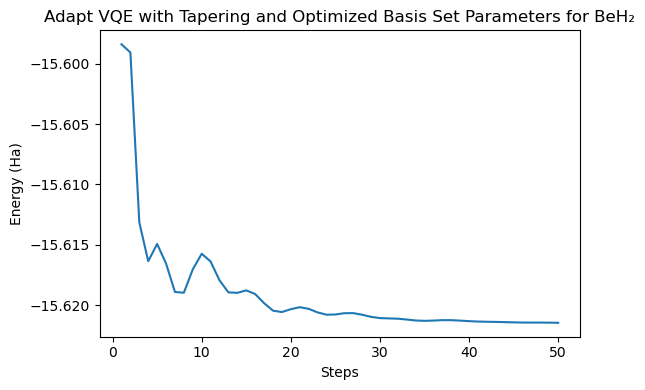

In [16]:
## Plotting the VQE iterations.
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(np.arange(1,50+1),adapt_energies)
plt.xlabel("Steps")
plt.ylabel("Energy (Ha)")
plt.title('Adapt VQE with Tapering and Optimized Basis Set Parameters for BeH₂')
plt.tight_layout()